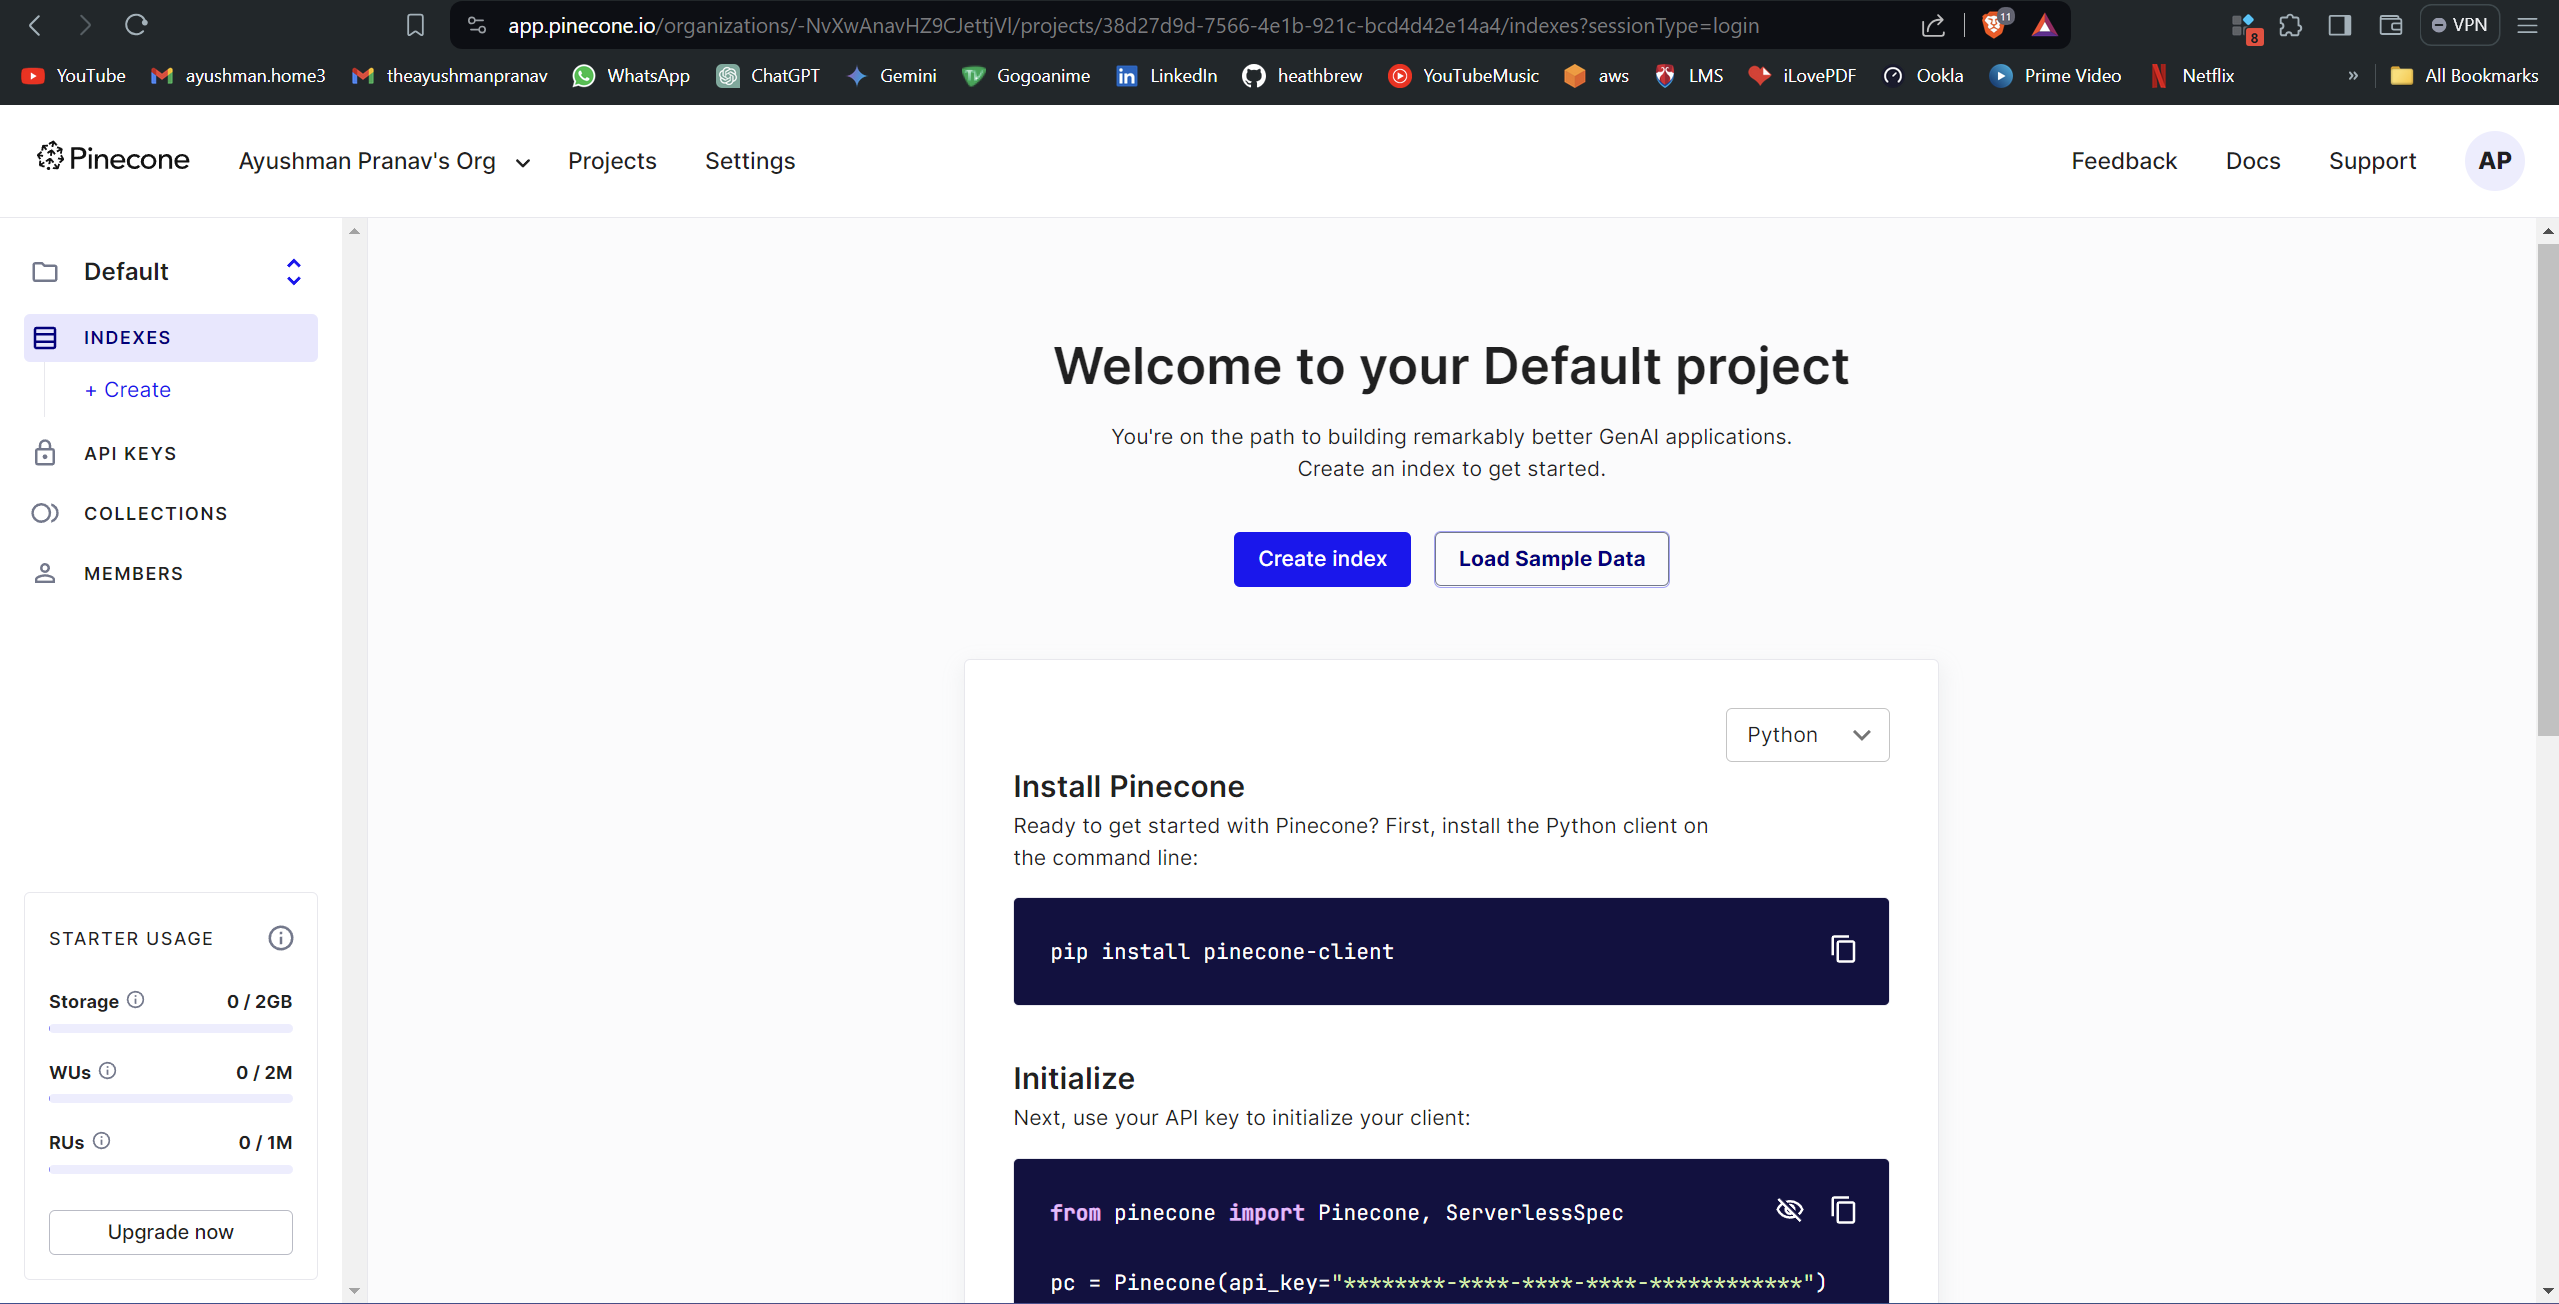

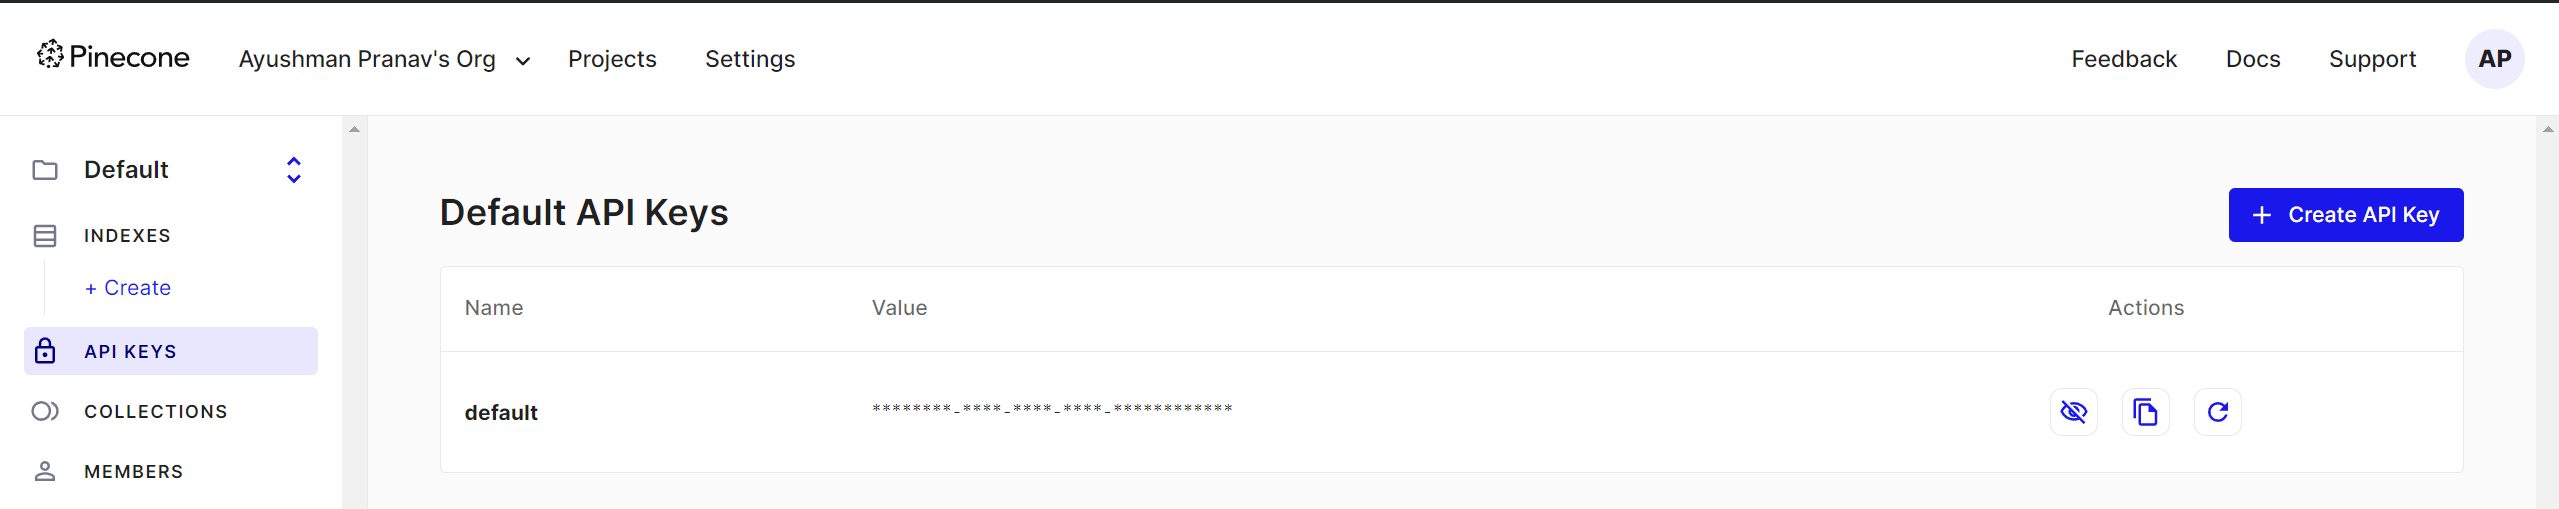

In [1]:
import os

In [2]:
%pwd

'D:\\Desktop\\Superteams AI\\Task 2 Vector Databases can help with Anomaly Detection\\Vector-Databases-can-help-with-Anomaly-Detection\\Research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'D:\\Desktop\\Superteams AI\\Task 2 Vector Databases can help with Anomaly Detection\\Vector-Databases-can-help-with-Anomaly-Detection'

In [5]:
import logging
from pathlib import Path
logging.basicConfig(
    # filename='extract_data.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [6]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("Dataset/financial_news.csv")
df.head()

,title,summary,link,published
0,India's exports dip marginally in March; 3.11%...,India's exports dip marginally in March; 3.11%...,https://realtime.rediff.com/news/business/Indi...,1 hour(s) ago
1,Vi expects 5G rollout in 6-9 months after FPO,Vi expects 5G rollout in 6-9 months after FPO\...,https://realtime.rediff.com/news/business/Vi-e...,2 hour(s) ago
2,"Byju's India CEO Arjun Mohan quits, Raveendran...","Byju's India CEO Arjun Mohan quits, Raveendran...",https://realtime.rediff.com/news/business/Byju...,3 hour(s) ago
3,"Sensex, Nifty tank over 1% on concerns over Mi...","Sensex, Nifty tank over 1% on concerns over Mi...",https://realtime.rediff.com/news/business/Sens...,6 hour(s) ago
4,Wholesale inflation inches up marginally to 0....,Wholesale inflation inches up marginally to 0....,https://realtime.rediff.com/news/business/Whol...,7 hour(s) ago


In [7]:
logging.info("Loaded financial news dataset")

2024-04-18 19:45:53 - INFO - Loaded financial news dataset


# Loading embeddding Model

In [8]:
from sentence_transformers import SentenceTransformer

D:\Desktop\Superteams AI\Task 2 Vector Databases can help with Anomaly Detection\Vector-Databases-can-help-with-Anomaly-Detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# from transformers import AutoTokenizer, AutoModel
# from pathlib import Path

# def download_model_and_tokenizer(model_name, save_path):
#     """
#     Download and save both the model and the tokenizer to the specified directory.

#     Parameters:
#         model_name (str): Name of the model to download.
#         save_path (str or Path): Path to the directory where the model and tokenizer will be saved.
#     """
#     # Create the save path if it doesn't exist
#     save_path = Path(save_path)
#     save_path.mkdir(parents=True, exist_ok=True)
    
#     # Initialize tokenizer and model
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model = AutoModel.from_pretrained(model_name)
    
#     # Save tokenizer
#     tokenizer.save_pretrained(save_path)
    
#     # Save model
#     model.save_pretrained(save_path)

# # Example usage
# model_name = 'sentence-transformers/all-MiniLM-L12-v2'  # Model name to download
# save_path = Path("MiniLM-L12-v2/")  # Path where model and tokenizer will be saved
# download_model_and_tokenizer(model_name, save_path)


In [10]:
from transformers import AutoTokenizer, AutoModel

def load_model_and_tokenizer(model_path):
    """
    Load the model and tokenizer from the specified directory.

    Parameters:
        model_path (str or Path): Path to the directory containing the saved model and tokenizer.

    Returns:
        tokenizer (transformers.PreTrainedTokenizer): Loaded tokenizer.
        model (transformers.PreTrainedModel): Loaded model.
    """
    model_path = Path(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    return tokenizer, model

# Load the model and tokenizer
model_path = Path("MiniLM-L12-v2/")
tokenizer, model = load_model_and_tokenizer(model_path)

In [11]:
logging.info("Initialized SentenceTransformer model")

2024-04-18 19:46:00 - INFO - Initialized SentenceTransformer model


In [12]:
df['news'] = df.apply(lambda row: row['title'] + ' ' + row['summary'], axis=1)
df.head()

,title,summary,link,published,news
0,India's exports dip marginally in March; 3.11%...,India's exports dip marginally in March; 3.11%...,https://realtime.rediff.com/news/business/Indi...,1 hour(s) ago,India's exports dip marginally in March; 3.11%...
1,Vi expects 5G rollout in 6-9 months after FPO,Vi expects 5G rollout in 6-9 months after FPO\...,https://realtime.rediff.com/news/business/Vi-e...,2 hour(s) ago,Vi expects 5G rollout in 6-9 months after FPO ...
2,"Byju's India CEO Arjun Mohan quits, Raveendran...","Byju's India CEO Arjun Mohan quits, Raveendran...",https://realtime.rediff.com/news/business/Byju...,3 hour(s) ago,"Byju's India CEO Arjun Mohan quits, Raveendran..."
3,"Sensex, Nifty tank over 1% on concerns over Mi...","Sensex, Nifty tank over 1% on concerns over Mi...",https://realtime.rediff.com/news/business/Sens...,6 hour(s) ago,"Sensex, Nifty tank over 1% on concerns over Mi..."
4,Wholesale inflation inches up marginally to 0....,Wholesale inflation inches up marginally to 0....,https://realtime.rediff.com/news/business/Whol...,7 hour(s) ago,Wholesale inflation inches up marginally to 0....


# embedding the data 

In [13]:
import torch

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def generate_embedding(text):
    # Tokenize input text
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    # Compute token embeddings with model
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Perform mean pooling
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    # Convert to numpy for FAISS compatibility and ensure it's 2D
    return sentence_embedding.cpu().numpy().reshape(1, -1)

In [14]:
# Generate embeddings for the 'input' column
df['encoded_news'] = df['news'].apply(lambda x: generate_embedding(x)[0].tolist())
df.head()

,title,summary,link,published,news,encoded_news
0,India's exports dip marginally in March; 3.11%...,India's exports dip marginally in March; 3.11%...,https://realtime.rediff.com/news/business/Indi...,1 hour(s) ago,India's exports dip marginally in March; 3.11%...,"[0.11521313339471817, -0.300284206867218, -0.0..."
1,Vi expects 5G rollout in 6-9 months after FPO,Vi expects 5G rollout in 6-9 months after FPO\...,https://realtime.rediff.com/news/business/Vi-e...,2 hour(s) ago,Vi expects 5G rollout in 6-9 months after FPO ...,"[-0.11326470226049423, -0.1829032599925995, 0...."
2,"Byju's India CEO Arjun Mohan quits, Raveendran...","Byju's India CEO Arjun Mohan quits, Raveendran...",https://realtime.rediff.com/news/business/Byju...,3 hour(s) ago,"Byju's India CEO Arjun Mohan quits, Raveendran...","[0.169069305062294, 0.021063419058918953, -0.1..."
3,"Sensex, Nifty tank over 1% on concerns over Mi...","Sensex, Nifty tank over 1% on concerns over Mi...",https://realtime.rediff.com/news/business/Sens...,6 hour(s) ago,"Sensex, Nifty tank over 1% on concerns over Mi...","[0.08247419446706772, -0.09446192532777786, -0..."
4,Wholesale inflation inches up marginally to 0....,Wholesale inflation inches up marginally to 0....,https://realtime.rediff.com/news/business/Whol...,7 hour(s) ago,Wholesale inflation inches up marginally to 0....,"[0.2434849739074707, 0.027635755017399788, 0.0..."


# Creating a vector store in pine cone 

In [15]:
from pinecone import Pinecone, ServerlessSpec
from pineconeapikey import pineconeapikey

In [16]:
# Initialize Pinecone
pc = Pinecone(api_key=pineconeapikey())
logging.info("Initialized Pinecone")


2024-04-18 19:46:03 - INFO - Initialized Pinecone


In [17]:
index_name = "financial-news-index"

# Check if the index already exists
if 'financial-news-index' not in pc.list_indexes().names():
    logging.info(f"Creating new index: {index_name}")
    # Get the embedding dimension from the model configuration
    embedding_dim = model.config.hidden_size
    # Create a new index if it doesn't already exist
    pc.create_index(
        name=index_name,
        dimension=embedding_dim,
        metric="cosine",
        spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    ) 
    )
else:
    logging.info(f"Index '{index_name}' already exists")

index = pc.Index(index_name)

2024-04-18 19:46:04 - INFO - Index 'financial-news-index' already exists


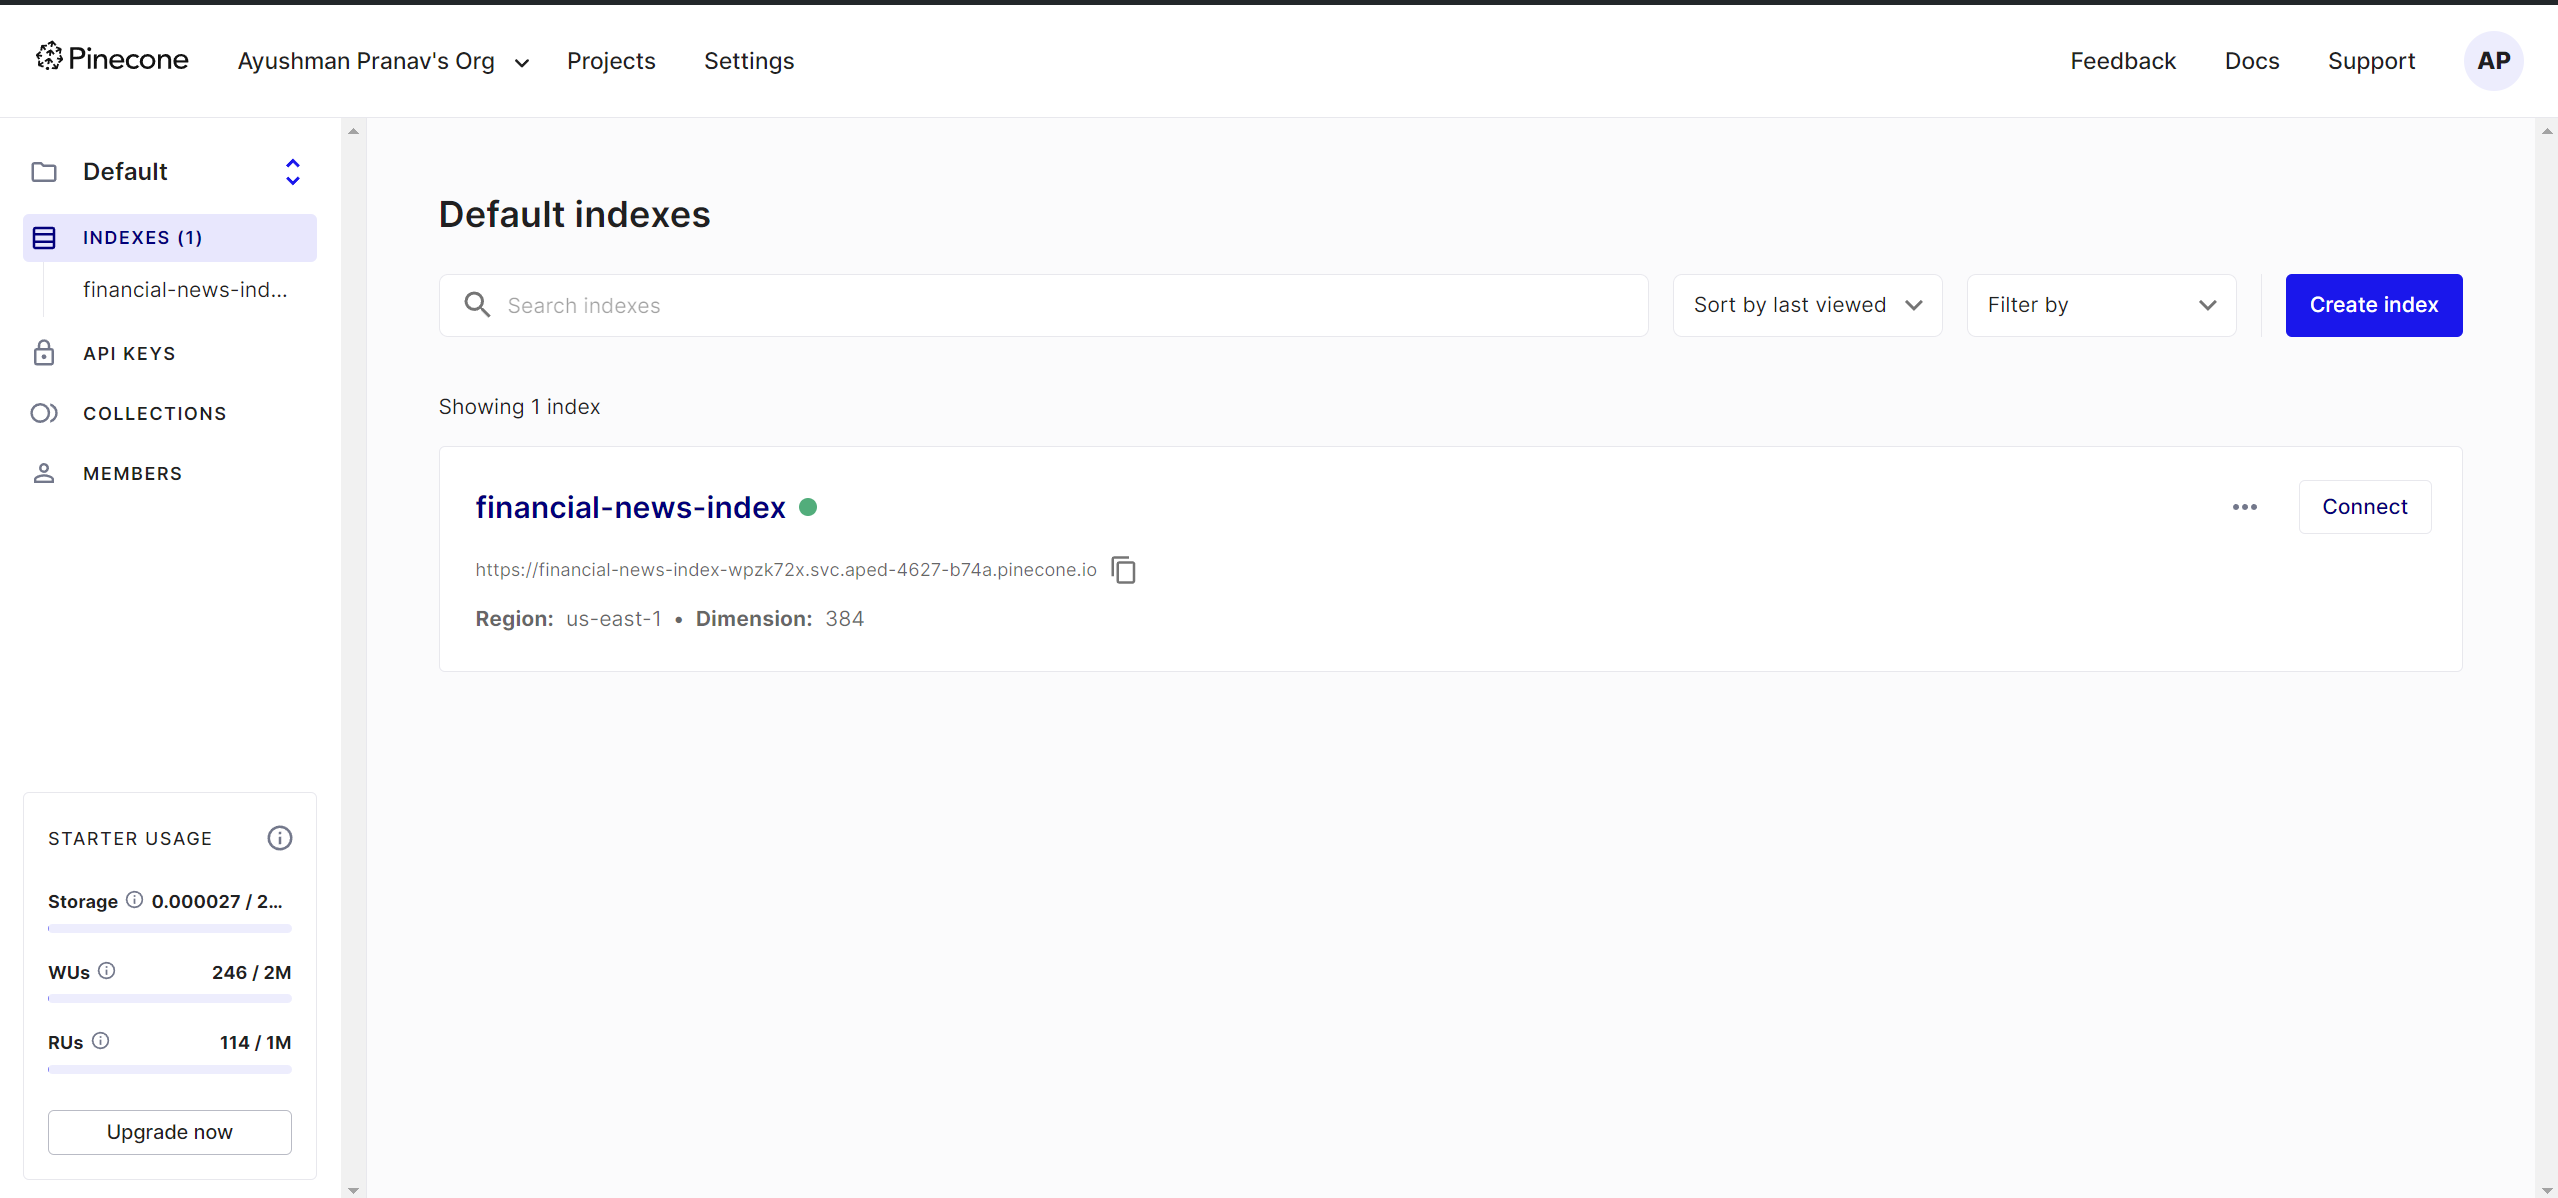

# pushing data to pine cone

In [18]:
import itertools

# Initialize Pinecone and create an index
pc = Pinecone(api_key=pineconeapikey())
index = pc.Index(index_name)

def chunks(iterable, batch_size=100):
    """A helper function to break an iterable into chunks of size batch_size."""
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))



# Extract necessary columns from the DataFrame
encoded_news = df['encoded_news']
news = df['news']

# Process the data and combine into a list of dictionaries
formatted_data = []
for idx, (encoded, text) in enumerate(zip(encoded_news, news)):
    try:
        # Create a dictionary representing a data point
        data_point = {"id": str(idx), "values": encoded, "metadata": {"text": text}}
        formatted_data.append(data_point)
        logging.info(f"Processed and encoded summary {idx + 1}")
    except Exception as e:
        logging.error(f"Error processing data point {idx + 1}: {e}")
        continue  # Skip to the next data point if an error occurs

# Upsert the formatted embeddings to the index in batches
for ids_vectors_chunk in chunks(formatted_data, batch_size=10):
    index.upsert(vectors=ids_vectors_chunk)  


2024-04-18 19:46:05 - INFO - Processed and encoded summary 1
2024-04-18 19:46:05 - INFO - Processed and encoded summary 2
2024-04-18 19:46:05 - INFO - Processed and encoded summary 3
2024-04-18 19:46:05 - INFO - Processed and encoded summary 4
2024-04-18 19:46:05 - INFO - Processed and encoded summary 5
2024-04-18 19:46:05 - INFO - Processed and encoded summary 6
2024-04-18 19:46:05 - INFO - Processed and encoded summary 7
2024-04-18 19:46:05 - INFO - Processed and encoded summary 8
2024-04-18 19:46:05 - INFO - Processed and encoded summary 9
2024-04-18 19:46:05 - INFO - Processed and encoded summary 10


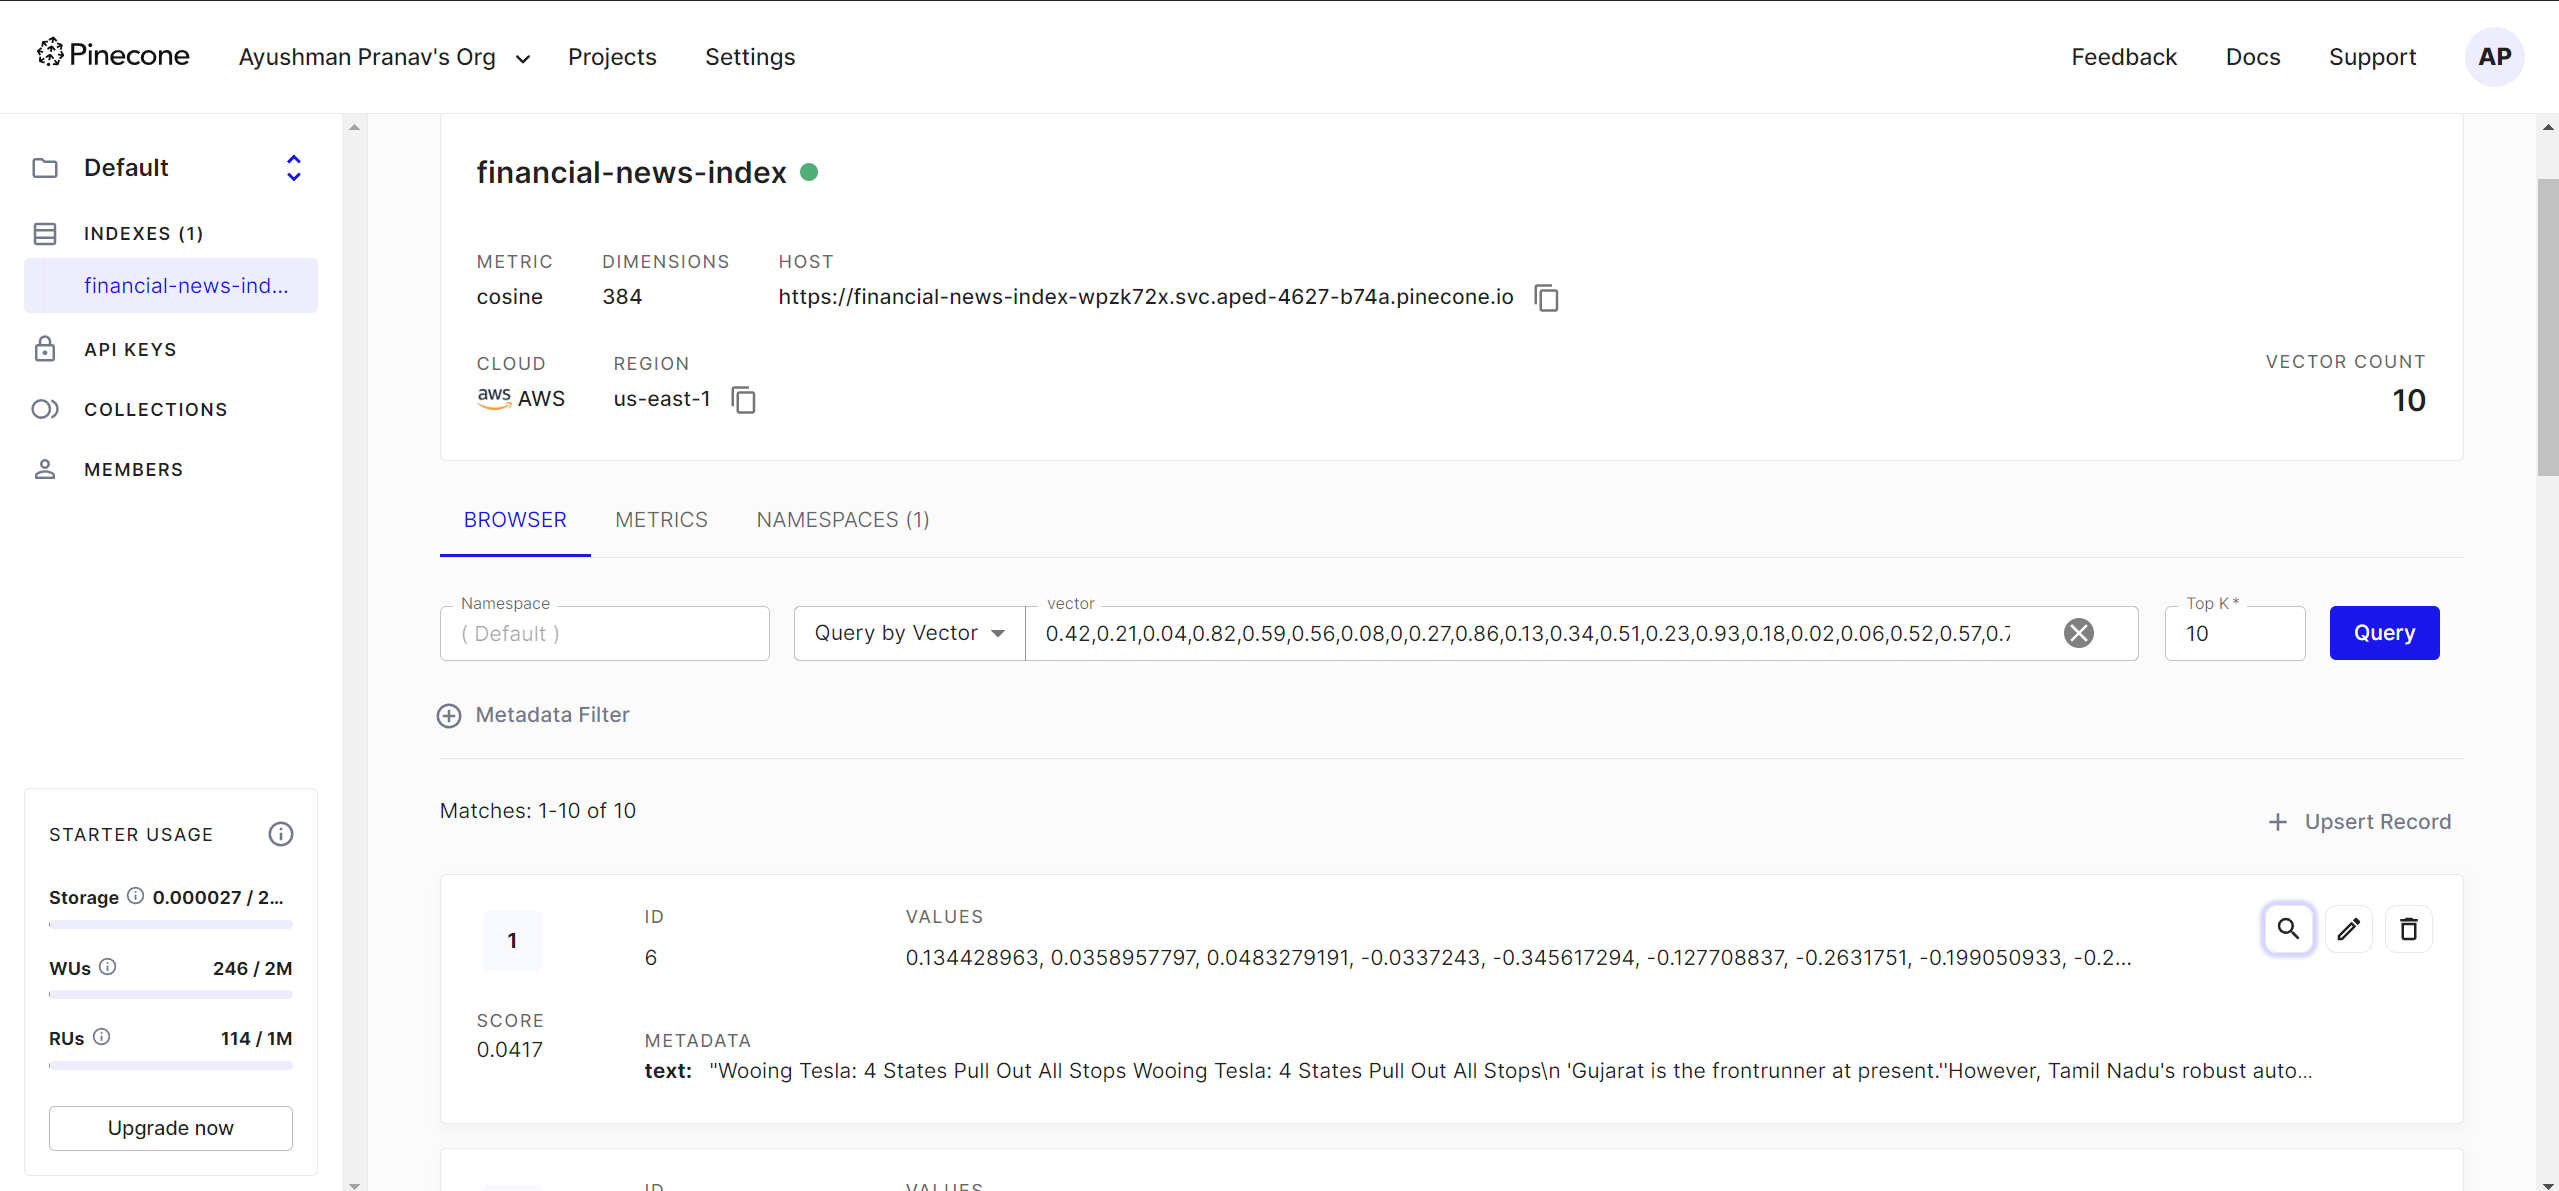

# Querying pinecone

In [ ]:
index_name = "financial-news-index"
index = pc.Index(index_name)

query = "Stock market crashes due to unexpected event"

# create the query vector
xq = generate_embedding(query).tolist()

# now query
xc = index.query(vector=xq, top_k=3, include_metadata=True)
xc

In [20]:
for result in xc['matches']:
    print(f"{round(result['score'], 2)}: {result['metadata']['text']}")

0.39: Sensex, Nifty tank over 1% on concerns over Middle East conflict Sensex, Nifty tank over 1% on concerns over Middle East conflict
            Stock markets took a beating on Monday with benchmark Sensex and Nifty tumbling over 1 per cent as escalating conflict in the Middle East and weak trends from global markets unnerved investors.  Photograph: PTI Photo from the Rediff Archives Extending losses to the second session, the 30-share BSE Sensex tanked 845.12 points or 1.14 per cent to settle at a more than two-week low of 73,399.78. During the day, it plunged 929.74 points or 1.25 per cent to 73,315.16. The NSE Nifty declined 246.90 ...
Rediff.com, 6 hour(s) ago
Also from:
0.35: FPIs jettison FMCG, auto shares in March voyage FPIs jettison FMCG, auto shares in March voyage
            Foreign portfolio investors (FPIs) were sellers of fast-moving consumer goods (FMCG), automotive (auto), and financial stocks during the second half of March.   Illustration: Dominic Xavier/Rediff.co

In [21]:
# Initialize an empty string to store concatenated results
concatenated_results = ""

# Iterate over the matches and concatenate each result
for result in xc['matches']:
    concatenated_results += f"{round(result['score'], 2)}: {result['metadata']['text']}\n"

# Print or use the concatenated results as needed
print(concatenated_results)


0.39: Sensex, Nifty tank over 1% on concerns over Middle East conflict Sensex, Nifty tank over 1% on concerns over Middle East conflict
            Stock markets took a beating on Monday with benchmark Sensex and Nifty tumbling over 1 per cent as escalating conflict in the Middle East and weak trends from global markets unnerved investors.  Photograph: PTI Photo from the Rediff Archives Extending losses to the second session, the 30-share BSE Sensex tanked 845.12 points or 1.14 per cent to settle at a more than two-week low of 73,399.78. During the day, it plunged 929.74 points or 1.25 per cent to 73,315.16. The NSE Nifty declined 246.90 ...
Rediff.com, 6 hour(s) ago
Also from:
0.35: FPIs jettison FMCG, auto shares in March voyage FPIs jettison FMCG, auto shares in March voyage
            Foreign portfolio investors (FPIs) were sellers of fast-moving consumer goods (FMCG), automotive (auto), and financial stocks during the second half of March.   Illustration: Dominic Xavier/Rediff.co

# RAG using Llama2

In [22]:
print(str(query + concatenated_results)[:512])

Stock market crashes due to unexpected event0.39: Sensex, Nifty tank over 1% on concerns over Middle East conflict Sensex, Nifty tank over 1% on concerns over Middle East conflict
            Stock markets took a beating on Monday with benchmark Sensex and Nifty tumbling over 1 per cent as escalating conflict in the Middle East and weak trends from global markets unnerved investors.  Photograph: PTI Photo from the Rediff Archives Extending losses to the second session, the 30-share BSE Sensex tanked 845.12 


In [23]:
from llama2backend import generate_text

RAG_answer = generate_text(str(query + concatenated_results)[:512])

D:\Desktop\Superteams AI\Task 2 Vector Databases can help with Anomaly Detection\Vector-Databases-can-help-with-Anomaly-Detection\venv\Lib\site-packages\langchain_core\utils\utils.py:159: UserWarning: WARNING! model_url is not default parameter.
                model_url was transferred to model_kwargs.
                Please confirm that model_url is what you intended.
  warnings.warn(
D:\Desktop\Superteams AI\Task 2 Vector Databases can help with Anomaly Detection\Vector-Databases-can-help-with-Anomaly-Detection\venv\Lib\site-packages\langchain_core\utils\utils.py:159: UserWarning: WARNING! max_new_tokens is not default parameter.
                max_new_tokens was transferred to model_kwargs.
                Please confirm that max_new_tokens is what you intended.
  warnings.warn(
D:\Desktop\Superteams AI\Task 2 Vector Databases can help with Anomaly Detection\Vector-Databases-can-help-with-Anomaly-Detection\venv\Lib\site-packages\langchain_core\utils\utils.py:159: UserWarning: WARN

 points or 2.79 per cent to settle at 29,677.47, while the broader Nifty plummeted 270.7 points or 2.83 per cent to finish at 9,477.50.
The sell-off was led by heavyweight stocks such as Reliance Industries, Tata Steel, HUL and Infosys, which declined up to 3 per cent each. The market breadth was weak with only 16 gainers against 42 losers on the Sensex and 20 winners versus 30 losers on the Nifty.
The global economic growth concerns, escalating tensions in the Middle East and a sharp decline in crude oil prices weighed heavily on investor sentiment, analysts said. The US-Iran conflict has intensified after top Iranian and US military commanders were killed in a US drone strike last week, raising fears of a wider conflict in the region.
The Indian rupee also weakened to a new record low of 76.94 against the dollar, adding to investor


llama_print_timings:        load time =     563.83 ms
llama_print_timings:      sample time =     102.50 ms /   256 runs   (    0.40 ms per token,  2497.56 tokens per second)
llama_print_timings: prompt eval time =    1126.01 ms /   142 tokens (    7.93 ms per token,   126.11 tokens per second)
llama_print_timings:        eval time =    5704.16 ms /   255 runs   (   22.37 ms per token,    44.70 tokens per second)
llama_print_timings:       total time =    8640.61 ms /   397 tokens


In [24]:
RAG_answer

' points or 2.79 per cent to settle at 29,677.47, while the broader Nifty plummeted 270.7 points or 2.83 per cent to finish at 9,477.50.\nThe sell-off was led by heavyweight stocks such as Reliance Industries, Tata Steel, HUL and Infosys, which declined up to 3 per cent each. The market breadth was weak with only 16 gainers against 42 losers on the Sensex and 20 winners versus 30 losers on the Nifty.\nThe global economic growth concerns, escalating tensions in the Middle East and a sharp decline in crude oil prices weighed heavily on investor sentiment, analysts said. The US-Iran conflict has intensified after top Iranian and US military commanders were killed in a US drone strike last week, raising fears of a wider conflict in the region.\nThe Indian rupee also weakened to a new record low of 76.94 against the dollar, adding to investor'